**Things to talk about with John**
- Discretionary futures trading:
    - Raw performance
    - Good, bad and ugly
    - Summary metrics and what they imply
    - AI feedback
- Stock picking algorithm:
    - Scoring metrics weighting
    - Rank vs pct_change correlation
    - Training weights on pct_change
- Programmatic futures trading:
    - RSI, MA mean reversion charts
    - Likelihood of success and profit expectation
    - Searching more parameters
    - improving efficiency and memory issues (keeping environment unencumbered by saving to and loading from disk)

# <h1 style="color:red;">Setup</h>

In [1]:
import pandas as pd
import os
import schwabdev
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import glob

Set the display options.

In [2]:
# Display options
# Set the global float format to 4 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

Load environment variables from .env file for authentification purposes.

In [3]:
load_dotenv()

True

Create the client object.

In [4]:
app_key = os.getenv('app_key')
app_secret = os.getenv('app_secret')
callback_url = os.getenv('callback_url')

# Print them to verify (avoid printing sensitive info in production)
print(f"App Key: {app_key}")
print(f"App Secret: {app_secret}")
print(f"Callback URL: {callback_url}")

# Now proceed to initialize the client
client = schwabdev.Client(app_key, app_secret, callback_url)
print('Client initialized!')

App Key: 2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150
App Secret: OQGxH0GkD5bAEMA4
Callback URL: https://127.0.0.1
Client initialized!


# <h1 style="color:red;">Data Preprocessing</h>

Call in discretionary futures trading performance csv files and display them for inspection. 

In [5]:
pd.reset_option('display.max_rows') # Display default abbreviated rows
# pd.set_option('display.max_rows', None) # Displays all rows
pd.set_option("display.max_columns", None) # Displays all column

# Find all Performance*.csv files
performance_files = sorted(glob.glob("Performance*.csv"))

print("Loading files:")
for f in performance_files:
    print(f" - {f}")

# Read and concatenate
performance_df = pd.concat(
    (pd.read_csv(f) for f in performance_files),
    ignore_index=True
)

# Drop exact duplicate rows
performance_df = performance_df.drop_duplicates().reset_index(drop=True)

display(performance_df)

Loading files:
 - Performance.csv
 - Performance1.csv
 - Performance2.csv
 - Performance3.csv


,symbol,_priceFormat,_priceFormatType,_tickSize,buyFillId,sellFillId,qty,buyPrice,sellPrice,pnl,boughtTimestamp,soldTimestamp,duration
0,ESZ5,-2,0,0.2500,277707851896,277707851918,2,"6,775.5000","6,770.5000",$(500.00),10/03/2025 04:32:25,10/03/2025 05:44:23,1h 11min 58sec
1,ESZ5,-2,0,0.2500,277707851938,277707851962,2,"6,770.0000","6,775.0000",$500.00,10/08/2025 05:45:54,10/08/2025 06:20:11,34min 16sec
2,ESZ5,-2,0,0.2500,277707851977,277707851999,2,"6,768.2500","6,773.2500",$500.00,10/08/2025 06:36:23,10/08/2025 06:47:37,11min 13sec
3,ESZ5,-2,0,0.2500,277707852014,277707852040,2,"6,788.2500","6,793.2500",$500.00,10/08/2025 07:45:57,10/08/2025 08:11:32,25min 34sec
4,ESZ5,-2,0,0.2500,277707852131,277707852072,2,"6,799.0000","6,800.0000",$100.00,10/08/2025 11:32:21,10/08/2025 09:16:01,2h 16min 19sec
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ESH6,-2,0,0.2500,333363743542,333363743512,1,"6,944.0000","6,956.2500",$612.50,12/30/2025 00:23:39,12/29/2025 22:10:09,2h 13min 29sec
235,ESH6,-2,0,0.2500,333363743557,333363743629,2,"6,949.5000","6,955.5000",$600.00,12/30/2025 07:39:14,12/30/2025 07:49:23,10min 9sec
236,ESH6,-2,0,0.2500,333363743599,333363743637,2,"6,947.7500","6,955.5000",$775.00,12/30/2025 07:42:10,12/30/2025 07:49:23,7min 13sec
237,ESH6,-2,0,0.2500,333363743655,333363743734,2,"6,945.7500","6,955.5000",$975.00,12/30/2025 08:13:27,12/30/2025 09:18:01,1h 4min 34sec


Convert `pnl` from string format to float as `pnl_usd`. Convert `boughtTimestamp` and `soldTimestamp` from string format to datetime objects as `bought_ts` and `sold_ts` respectively (timezone-naive). Calculate duration of each trade as `duration_td` and `cumulative_pnl` in brokerage-native order. 

In [6]:
def parse_pnl(pnl_string):
    pnl_string = pnl_string.strip()
    negative = pnl_string.startswith('$(') or pnl_string.startswith('(')
    pnl_string = pnl_string.replace('$', '').replace('(', '').replace(')', '').replace(',', '')
    pnl_val = float(pnl_string)
    return -pnl_val if negative else pnl_val

performance_df['pnl_usd'] = performance_df['pnl'].apply(parse_pnl)

performance_df['bought_ts'] = pd.to_datetime(performance_df['boughtTimestamp'], format="%m/%d/%Y %H:%M:%S")
performance_df['sold_ts']   = pd.to_datetime(performance_df['soldTimestamp'],  format="%m/%d/%Y %H:%M:%S")
performance_df['duration_td'] = performance_df['sold_ts'] - performance_df['bought_ts']
performance_df['cumulative_pnl'] = performance_df['pnl_usd'].cumsum()

# Drop columns that are no longer needed
performance_df = performance_df.drop(columns=['boughtTimestamp', 'soldTimestamp', 'pnl', '_priceFormat', '_priceFormatType', 'duration'])

In [7]:
performance_df['tick_value_usd'] = 12.5
performance_df['stop_loss_ticks'] = 40
performance_df['take_profit_ticks'] = 40
performance_df['stop_loss_usd'] = performance_df['stop_loss_ticks'] * performance_df['tick_value_usd'] * performance_df['qty']
performance_df['take_profit_usd'] = performance_df['take_profit_ticks'] * performance_df['tick_value_usd'] * performance_df['qty']

In [8]:
display(performance_df)

,symbol,_tickSize,buyFillId,sellFillId,qty,buyPrice,sellPrice,pnl_usd,bought_ts,sold_ts,duration_td,cumulative_pnl,tick_value_usd,stop_loss_ticks,take_profit_ticks,stop_loss_usd,take_profit_usd
0,ESZ5,0.2500,277707851896,277707851918,2,"6,775.5000","6,770.5000",-500.0000,2025-10-03 04:32:25,2025-10-03 05:44:23,0 days 01:11:58,-500.0000,12.5000,40,40,"1,000.0000","1,000.0000"
1,ESZ5,0.2500,277707851938,277707851962,2,"6,770.0000","6,775.0000",500.0000,2025-10-08 05:45:54,2025-10-08 06:20:11,0 days 00:34:17,0.0000,12.5000,40,40,"1,000.0000","1,000.0000"
2,ESZ5,0.2500,277707851977,277707851999,2,"6,768.2500","6,773.2500",500.0000,2025-10-08 06:36:23,2025-10-08 06:47:37,0 days 00:11:14,500.0000,12.5000,40,40,"1,000.0000","1,000.0000"
3,ESZ5,0.2500,277707852014,277707852040,2,"6,788.2500","6,793.2500",500.0000,2025-10-08 07:45:57,2025-10-08 08:11:32,0 days 00:25:35,"1,000.0000",12.5000,40,40,"1,000.0000","1,000.0000"
4,ESZ5,0.2500,277707852131,277707852072,2,"6,799.0000","6,800.0000",100.0000,2025-10-08 11:32:21,2025-10-08 09:16:01,-1 days +21:43:40,"1,100.0000",12.5000,40,40,"1,000.0000","1,000.0000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ESH6,0.2500,333363743542,333363743512,1,"6,944.0000","6,956.2500",612.5000,2025-12-30 00:23:39,2025-12-29 22:10:09,-1 days +21:46:30,"-89,937.5000",12.5000,40,40,500.0000,500.0000
235,ESH6,0.2500,333363743557,333363743629,2,"6,949.5000","6,955.5000",600.0000,2025-12-30 07:39:14,2025-12-30 07:49:23,0 days 00:10:09,"-89,337.5000",12.5000,40,40,"1,000.0000","1,000.0000"
236,ESH6,0.2500,333363743599,333363743637,2,"6,947.7500","6,955.5000",775.0000,2025-12-30 07:42:10,2025-12-30 07:49:23,0 days 00:07:13,"-88,562.5000",12.5000,40,40,"1,000.0000","1,000.0000"
237,ESH6,0.2500,333363743655,333363743734,2,"6,945.7500","6,955.5000",975.0000,2025-12-30 08:13:27,2025-12-30 09:18:01,0 days 01:04:34,"-87,587.5000",12.5000,40,40,"1,000.0000","1,000.0000"


Calculate long/short and win/loss columns as `trade_direction` and `trade_outcome` respectively.

In [9]:
def add_trade_classification(df):
    temp = df.copy()

    # ----------- Trade Direction -----------
    temp['trade_direction'] = np.where(
        temp['bought_ts'] < temp['sold_ts'],
        'long',
        'short'
    )

    # ----------- Trade Outcome -----------
    temp['trade_outcome'] = np.where(
        temp['pnl_usd'] > 0,  'win',
        np.where(temp['pnl_usd'] < 0, 'loss', 'flat')
    )

    return temp

performance_df = add_trade_classification(performance_df)

View columns related to `trade_direction` and `trade_outcome` columns to ensure accurate calculation.

In [10]:
pd.reset_option('display.max_rows') # Display default abbreviated rows
pd.set_option("display.max_columns", None)

print(performance_df[['buyPrice', 'sellPrice', 'bought_ts', 'sold_ts', 'pnl_usd', 'trade_direction', 'trade_outcome']])

      buyPrice  sellPrice           bought_ts             sold_ts   pnl_usd trade_direction trade_outcome
0   6,775.5000 6,770.5000 2025-10-03 04:32:25 2025-10-03 05:44:23 -500.0000            long          loss
1   6,770.0000 6,775.0000 2025-10-08 05:45:54 2025-10-08 06:20:11  500.0000            long           win
2   6,768.2500 6,773.2500 2025-10-08 06:36:23 2025-10-08 06:47:37  500.0000            long           win
3   6,788.2500 6,793.2500 2025-10-08 07:45:57 2025-10-08 08:11:32  500.0000            long           win
4   6,799.0000 6,800.0000 2025-10-08 11:32:21 2025-10-08 09:16:01  100.0000           short           win
..         ...        ...                 ...                 ...       ...             ...           ...
234 6,944.0000 6,956.2500 2025-12-30 00:23:39 2025-12-29 22:10:09  612.5000           short           win
235 6,949.5000 6,955.5000 2025-12-30 07:39:14 2025-12-30 07:49:23  600.0000            long           win
236 6,947.7500 6,955.5000 2025-12-30 07:42:10 

# <h1 style="color:red;">Pull Schwab Futures Data</h>

In [11]:
# --- Map your performance symbols to Schwab API symbols ---
def map_performance_symbol_to_schwab(symbol: str) -> str:
    """
    Map platform/export symbols (e.g., 'ESZ5') to Schwab API symbols (e.g., '/ES').
    Extend this mapping as needed for other contracts.
    """
    if symbol.startswith("ES"):
        return "/ES"
    if symbol.startswith("NQ"):
        return "/NQ"
    # Fallback: return as-is, or raise if you prefer strict behavior
    return symbol


# --- Minute-level Schwab data fetcher using start/end dates ---
def get_schwab_minute_data(symbol, start, end, exchange=None, chunk_days=30):
    """
    Fetch 1-minute OHLC candles for a symbol from the Schwab API between start and end (datetime),
    chunked by `chunk_days` to respect API limits.
    """
    all_candles = []
    window_start = start

    while window_start < end:
        window_end = min(window_start + timedelta(days=chunk_days), end)

        try:
            response = client.price_history(
                symbol=symbol,
                frequencyType='minute',
                frequency=5,
                startDate=window_start,
                endDate=window_end,
                needExtendedHoursData=False,
            )
            json_data = response.json()

            # if 'candles' in json_data and json_data['candles']:
            for candle in json_data['candles']:
                candle["ticker"] = symbol
                candle["exchange"] = exchange
                all_candles.append(candle)
            # else:
            #     print(f"No candles returned for {symbol} in {window_start} → {window_end}")
        except Exception as e:
            print(f"Error fetching data for {symbol} in {window_start} → {window_end}: {e}")

        time.sleep(1)
        window_start = window_end + timedelta(minutes=1)

    return all_candles

Calculate individual trade time spans for use in developing more specific performance metrics later in the pipeline. Calculate a range of dates that surround all of the trade durations. 

In [12]:
# Per-row min/max across bought/sold
performance_df['row_min_ts'] = performance_df[['bought_ts', 'sold_ts']].min(axis=1)
performance_df['row_max_ts'] = performance_df[['bought_ts', 'sold_ts']].max(axis=1)

# Per-symbol global min/max
symbol_ranges = performance_df.groupby('symbol').agg(
    start_ts=('row_min_ts', 'min'),
    end_ts=('row_max_ts', 'max')
).reset_index()

display(symbol_ranges)

,symbol,start_ts,end_ts
0,ESH6,2025-12-16 05:17:22,2025-12-30 09:41:35
1,ESZ5,2025-10-03 04:32:25,2025-12-12 11:12:15


Fetching Schwab data for ES that spans the trade data by more than one day in both directions and saving it to csv.

In [13]:
minute_dfs = []

for i, row in symbol_ranges.iterrows():
    perf_symbol = row['symbol']
    api_symbol = map_performance_symbol_to_schwab(perf_symbol)

    start = row['start_ts'] - timedelta(days=1)
    end   = row['end_ts']   + timedelta(days=1)

    print(f"Fetching 1-min data for ({api_symbol}) from {start} to {end}...")

    df_tmp = pd.DataFrame(get_schwab_minute_data(api_symbol, start, end))
    minute_dfs.append(df_tmp)

    print(f"Fetched {len(df_tmp)} candles for {api_symbol}")

minute_df = pd.concat(minute_dfs, ignore_index=True)
minute_df['datetime'] = pd.to_datetime(minute_df['datetime'], unit='ms')
minute_df = minute_df.drop(columns=['exchange'])
minute_df = minute_df.sort_values(by=['datetime']).reset_index(drop=True)

minute_df.to_csv("ES_1min_all_contracts.csv", index=False)
print(f"Saved {len(minute_df)} total candles to ES_1min_all_contracts.csv")

Fetching 1-min data for (/ES) from 2025-12-15 05:17:22 to 2025-12-31 09:41:35...
Fetched 3044 candles for /ES
Fetching 1-min data for (/ES) from 2025-10-02 04:32:25 to 2025-12-13 11:12:15...
Fetched 14046 candles for /ES
Saved 17090 total candles to ES_1min_all_contracts.csv


In [14]:
pd.set_option('display.max_columns', None) # Displays all columns
pd.reset_option('display.max_rows') # Display default abbreviated rows
display(minute_df)

,open,high,low,close,volume,datetime,ticker
0,"6,767.0000","6,767.2500","6,766.7500","6,766.7500",125,2025-10-02 04:35:00,/ES
1,"6,766.7500","6,767.7500","6,766.2500","6,767.5000",372,2025-10-02 04:40:00,/ES
2,"6,767.7500","6,769.5000","6,767.7500","6,768.5000",414,2025-10-02 04:45:00,/ES
3,"6,768.5000","6,769.0000","6,767.7500","6,768.7500",231,2025-10-02 04:50:00,/ES
4,"6,768.5000","6,769.0000","6,768.2500","6,769.0000",206,2025-10-02 04:55:00,/ES
...,...,...,...,...,...,...,...
17085,"6,927.2500","6,928.2500","6,925.7500","6,925.7500",283,2025-12-31 09:20:00,/ES
17086,"6,926.0000","6,926.5000","6,924.7500","6,925.7500",467,2025-12-31 09:25:00,/ES
17087,"6,925.7500","6,926.5000","6,925.5000","6,925.7500",229,2025-12-31 09:30:00,/ES
17088,"6,925.7500","6,927.5000","6,925.7500","6,927.2500",352,2025-12-31 09:35:00,/ES


# <h1 style="color:red;">Macro Trade Performance</h>

In [15]:
def summarize_performance(df, loss_cap=None, win_cap=None):
    """
    Summarize trade performance with optional PnL capping.

    Args:
        df: DataFrame with columns:
            - 'trade_direction' ('long'/'short')
            - 'trade_outcome'  ('win'/'loss'/'flat')
            - 'pnl_usd'        (float)
        loss_cap: float or None
            If not None, any pnl_usd < loss_cap is set to loss_cap.
        win_cap: float or None
            If not None, any pnl_usd > win_cap is set to win_cap.

    Returns:
        dict of summary tables.
    """
    df_temp = df.copy()

    # Effective PnL after optional caps (symmetric, no direction bias)
    df_temp['pnl_effective'] = df_temp['pnl_usd']

    if loss_cap is not None:
        df_temp.loc[df_temp['pnl_effective'] < loss_cap, 'pnl_effective'] = loss_cap

    if win_cap is not None:
        df_temp.loc[df_temp['pnl_effective'] > win_cap, 'pnl_effective'] = win_cap

    # --- Counts ---
    direction_counts = df_temp['trade_direction'].value_counts()
    outcome_counts   = df_temp['trade_outcome'].value_counts()

    print("Trades by direction:")
    print(direction_counts)
    print("\nTrades by outcome:")
    print(outcome_counts)
    print()

    # --- Direction x Outcome counts ---
    combo_counts = pd.crosstab(
        df_temp['trade_direction'],
        df_temp['trade_outcome']
    )
    print("Count of trades by [direction x outcome]:")
    print(combo_counts)
    print()

    # --- Nominal PnL by direction (using capped PnL if applied) ---
    pnl_by_direction = df_temp.groupby('trade_direction')['pnl_effective'].sum()
    print("Total PnL by direction (using pnl_effective):")
    print(pnl_by_direction)
    print()

    # --- Nominal PnL by outcome ---
    pnl_by_outcome = df_temp.groupby('trade_outcome')['pnl_effective'].sum()
    print("Total PnL by outcome (using pnl_effective):")
    print(pnl_by_outcome)
    print()

    # --- PnL matrix: direction x outcome ---
    pnl_combo = pd.pivot_table(
        df_temp,
        values='pnl_effective',
        index='trade_direction',
        columns='trade_outcome',
        aggfunc='sum',
        fill_value=0
    )
    print("Total PnL by [direction x outcome] (using pnl_effective):")
    print(pnl_combo)
    print()

    # --- Average PnL per trade for each [direction x outcome] ---
    avg_pnl_combo = (
        df_temp
        .groupby(['trade_direction', 'trade_outcome'])['pnl_effective']
        .mean()
        .reset_index()
    )
    print("Average PnL per trade by [direction x outcome] (using pnl_effective):")
    print(avg_pnl_combo)
    print()

    return {
        "direction_counts": direction_counts,
        "outcome_counts": outcome_counts,
        "combo_counts": combo_counts,
        "pnl_by_direction": pnl_by_direction,
        "pnl_by_outcome": pnl_by_outcome,
        "pnl_combo": pnl_combo,
        "avg_pnl_combo": avg_pnl_combo,
        "df_with_pnl_effective": df_temp,
    }

Call `summarize_performance` on `performance_df` to get meta data on the raw trade data.

In [16]:
summary_actual = summarize_performance(performance_df)

Trades by direction:
trade_direction
long     170
short     69
Name: count, dtype: int64

Trades by outcome:
trade_outcome
win     147
loss     91
flat      1
Name: count, dtype: int64

Count of trades by [direction x outcome]:
trade_outcome    flat  loss  win
trade_direction                 
long                0    66  104
short               1    25   43

Total PnL by direction (using pnl_effective):
trade_direction
long    -97,375.0000
short    10,637.5000
Name: pnl_effective, dtype: float64

Total PnL by outcome (using pnl_effective):
trade_outcome
flat          0.0000
loss   -213,325.0000
win     126,587.5000
Name: pnl_effective, dtype: float64

Total PnL by [direction x outcome] (using pnl_effective):
trade_outcome     flat          loss          win
trade_direction                                  
long            0.0000 -197,412.5000 100,037.5000
short           0.0000  -15,912.5000  26,550.0000

Average PnL per trade by [direction x outcome] (using pnl_effective):
  trade_dir

**Put a summary of what these trade stats mean about my behavior/psychology as a trader.**

In [17]:
display(performance_df)

,symbol,_tickSize,buyFillId,sellFillId,qty,buyPrice,sellPrice,pnl_usd,bought_ts,sold_ts,duration_td,cumulative_pnl,tick_value_usd,stop_loss_ticks,take_profit_ticks,stop_loss_usd,take_profit_usd,trade_direction,trade_outcome,row_min_ts,row_max_ts
0,ESZ5,0.2500,277707851896,277707851918,2,"6,775.5000","6,770.5000",-500.0000,2025-10-03 04:32:25,2025-10-03 05:44:23,0 days 01:11:58,-500.0000,12.5000,40,40,"1,000.0000","1,000.0000",long,loss,2025-10-03 04:32:25,2025-10-03 05:44:23
1,ESZ5,0.2500,277707851938,277707851962,2,"6,770.0000","6,775.0000",500.0000,2025-10-08 05:45:54,2025-10-08 06:20:11,0 days 00:34:17,0.0000,12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-10-08 05:45:54,2025-10-08 06:20:11
2,ESZ5,0.2500,277707851977,277707851999,2,"6,768.2500","6,773.2500",500.0000,2025-10-08 06:36:23,2025-10-08 06:47:37,0 days 00:11:14,500.0000,12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-10-08 06:36:23,2025-10-08 06:47:37
3,ESZ5,0.2500,277707852014,277707852040,2,"6,788.2500","6,793.2500",500.0000,2025-10-08 07:45:57,2025-10-08 08:11:32,0 days 00:25:35,"1,000.0000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-10-08 07:45:57,2025-10-08 08:11:32
4,ESZ5,0.2500,277707852131,277707852072,2,"6,799.0000","6,800.0000",100.0000,2025-10-08 11:32:21,2025-10-08 09:16:01,-1 days +21:43:40,"1,100.0000",12.5000,40,40,"1,000.0000","1,000.0000",short,win,2025-10-08 09:16:01,2025-10-08 11:32:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ESH6,0.2500,333363743542,333363743512,1,"6,944.0000","6,956.2500",612.5000,2025-12-30 00:23:39,2025-12-29 22:10:09,-1 days +21:46:30,"-89,937.5000",12.5000,40,40,500.0000,500.0000,short,win,2025-12-29 22:10:09,2025-12-30 00:23:39
235,ESH6,0.2500,333363743557,333363743629,2,"6,949.5000","6,955.5000",600.0000,2025-12-30 07:39:14,2025-12-30 07:49:23,0 days 00:10:09,"-89,337.5000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-12-30 07:39:14,2025-12-30 07:49:23
236,ESH6,0.2500,333363743599,333363743637,2,"6,947.7500","6,955.5000",775.0000,2025-12-30 07:42:10,2025-12-30 07:49:23,0 days 00:07:13,"-88,562.5000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-12-30 07:42:10,2025-12-30 07:49:23
237,ESH6,0.2500,333363743655,333363743734,2,"6,945.7500","6,955.5000",975.0000,2025-12-30 08:13:27,2025-12-30 09:18:01,0 days 01:04:34,"-87,587.5000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-12-30 08:13:27,2025-12-30 09:18:01


Call `summarize_performance` on `performance_df` to get meta data on the raw trade data with a filter on negative trades that caps them at -1000.

In [18]:
loss_cap = -1000
summary_capped = summarize_performance(performance_df, loss_cap=loss_cap)

Trades by direction:
trade_direction
long     170
short     69
Name: count, dtype: int64

Trades by outcome:
trade_outcome
win     147
loss     91
flat      1
Name: count, dtype: int64

Count of trades by [direction x outcome]:
trade_outcome    flat  loss  win
trade_direction                 
long                0    66  104
short               1    25   43

Total PnL by direction (using pnl_effective):
trade_direction
long    48,800.0000
short   10,662.5000
Name: pnl_effective, dtype: float64

Total PnL by outcome (using pnl_effective):
trade_outcome
flat         0.0000
loss   -67,125.0000
win    126,587.5000
Name: pnl_effective, dtype: float64

Total PnL by [direction x outcome] (using pnl_effective):
trade_outcome     flat         loss          win
trade_direction                                 
long            0.0000 -51,237.5000 100,037.5000
short           0.0000 -15,887.5000  26,550.0000

Average PnL per trade by [direction x outcome] (using pnl_effective):
  trade_direction tr

**Put a summary of what these trade stats mean about my behavior/psychology as a trader who strictly obeys the risk of loss per trade parameter.**

In [19]:
def plot_cumulative_pnl(df, sort_by=None, ascending=True, min_pnl=None, max_pnl=None):
    """
    Plot cumulative PnL using an optional capped-risk regime.

    This function optionally caps per-trade PnL to simulate honoring
    predefined risk limits, allows sorting trades by a chosen column
    before aggregation, and plots the resulting cumulative PnL using
    the DataFrame index as the x-axis.

    Args:
        df (pd.DataFrame):
            Trade-level DataFrame containing at minimum a 'pnl_usd' column.
        sort_by (str, optional):
            Column name to sort trades by before computing cumulative PnL
            (e.g., 'pnl_usd', 'duration_td'). If None, original order is used.
        ascending (bool, optional):
            Sort order when sort_by is provided. Default is True.
        min_pnl (float, optional):
            Lower bound for per-trade PnL. Any trade with pnl_usd below this
            value is capped to min_pnl. If None, no lower cap is applied.
        max_pnl (float, optional):
            Upper bound for per-trade PnL. Any trade with pnl_usd above this
            value is capped to max_pnl. If None, no upper cap is applied.

    Returns:
        None
            Displays a matplotlib plot of cumulative PnL under the specified
            sorting and risk-capping regime.
    """
    df_temp = df.copy()

    # Capped PnL column for "what if I honored risk rules?"
    df_temp['pnl_capped'] = df_temp['pnl_usd']

    if min_pnl is not None:
        df_temp['pnl_capped'] = df_temp['pnl_capped'].mask(df_temp['pnl_capped'] < min_pnl, min_pnl)

    if max_pnl is not None:
        df_temp['pnl_capped'] = df_temp['pnl_capped'].mask(df_temp['pnl_capped'] > max_pnl, max_pnl)

    # Optional sorting (uses whatever column you ask for, usually 'pnl_usd' or 'duration_td')
    if sort_by is not None:
        df_temp = df_temp.sort_values(by=sort_by, ascending=ascending)

    # Reset index so x-axis is clean and sequential
    df_temp = df_temp.reset_index(drop=True)

    # Cumulative PnL under the risk regime (using capped PnL)
    df_temp['cumulative_pnl'] = df_temp['pnl_capped'].cumsum()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_temp.index, df_temp['cumulative_pnl'])
    plt.title(
        "Cumulative PnL" +
        (f" (sorted by '{sort_by}')" if sort_by else "")
        + (f" | capped at [{min_pnl if min_pnl is not None else '-∞'}, "
           f"{max_pnl if max_pnl is not None else '+∞'}]" if (min_pnl is not None or max_pnl is not None) else "")
    )
    plt.xlabel("Trade Number (Index)")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()

    # return temp

In [20]:
performance_df

,symbol,_tickSize,buyFillId,sellFillId,qty,buyPrice,sellPrice,pnl_usd,bought_ts,sold_ts,duration_td,cumulative_pnl,tick_value_usd,stop_loss_ticks,take_profit_ticks,stop_loss_usd,take_profit_usd,trade_direction,trade_outcome,row_min_ts,row_max_ts
0,ESZ5,0.2500,277707851896,277707851918,2,"6,775.5000","6,770.5000",-500.0000,2025-10-03 04:32:25,2025-10-03 05:44:23,0 days 01:11:58,-500.0000,12.5000,40,40,"1,000.0000","1,000.0000",long,loss,2025-10-03 04:32:25,2025-10-03 05:44:23
1,ESZ5,0.2500,277707851938,277707851962,2,"6,770.0000","6,775.0000",500.0000,2025-10-08 05:45:54,2025-10-08 06:20:11,0 days 00:34:17,0.0000,12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-10-08 05:45:54,2025-10-08 06:20:11
2,ESZ5,0.2500,277707851977,277707851999,2,"6,768.2500","6,773.2500",500.0000,2025-10-08 06:36:23,2025-10-08 06:47:37,0 days 00:11:14,500.0000,12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-10-08 06:36:23,2025-10-08 06:47:37
3,ESZ5,0.2500,277707852014,277707852040,2,"6,788.2500","6,793.2500",500.0000,2025-10-08 07:45:57,2025-10-08 08:11:32,0 days 00:25:35,"1,000.0000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-10-08 07:45:57,2025-10-08 08:11:32
4,ESZ5,0.2500,277707852131,277707852072,2,"6,799.0000","6,800.0000",100.0000,2025-10-08 11:32:21,2025-10-08 09:16:01,-1 days +21:43:40,"1,100.0000",12.5000,40,40,"1,000.0000","1,000.0000",short,win,2025-10-08 09:16:01,2025-10-08 11:32:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ESH6,0.2500,333363743542,333363743512,1,"6,944.0000","6,956.2500",612.5000,2025-12-30 00:23:39,2025-12-29 22:10:09,-1 days +21:46:30,"-89,937.5000",12.5000,40,40,500.0000,500.0000,short,win,2025-12-29 22:10:09,2025-12-30 00:23:39
235,ESH6,0.2500,333363743557,333363743629,2,"6,949.5000","6,955.5000",600.0000,2025-12-30 07:39:14,2025-12-30 07:49:23,0 days 00:10:09,"-89,337.5000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-12-30 07:39:14,2025-12-30 07:49:23
236,ESH6,0.2500,333363743599,333363743637,2,"6,947.7500","6,955.5000",775.0000,2025-12-30 07:42:10,2025-12-30 07:49:23,0 days 00:07:13,"-88,562.5000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-12-30 07:42:10,2025-12-30 07:49:23
237,ESH6,0.2500,333363743655,333363743734,2,"6,945.7500","6,955.5000",975.0000,2025-12-30 08:13:27,2025-12-30 09:18:01,0 days 01:04:34,"-87,587.5000",12.5000,40,40,"1,000.0000","1,000.0000",long,win,2025-12-30 08:13:27,2025-12-30 09:18:01


Insight: PnL totally wrecked by two heavy days of market weakness. The habit to change would be not to average down when the trade goes against you.
Take the loss on the initial bet, don't be arrogant about that decision.
Either stay out when action is choppy and negative, or find the nerve and build the skill to sell into weakness.


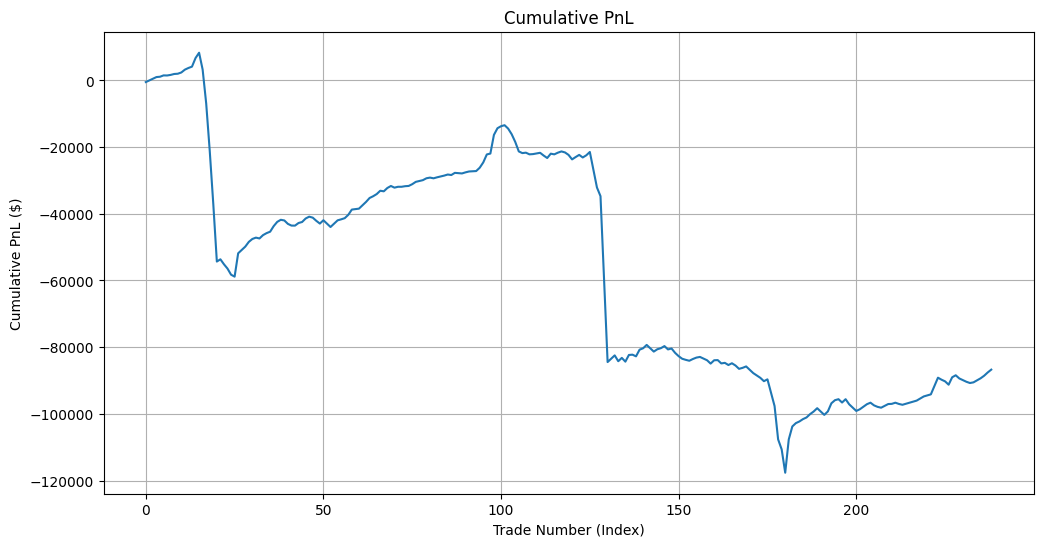

Insight: Had you obeyed a -$1000 per trade risk parameter, your performance would have improved monumentally.
You need to review the impact of obeyence of risk parameter on PnL figures. Enlighten yourself on why you did so well between trade 25 and 125.
Your attitude, behavioral patterns, and their interactions with the technical/fundamental environments of the time are key to maintaining consistent profitability


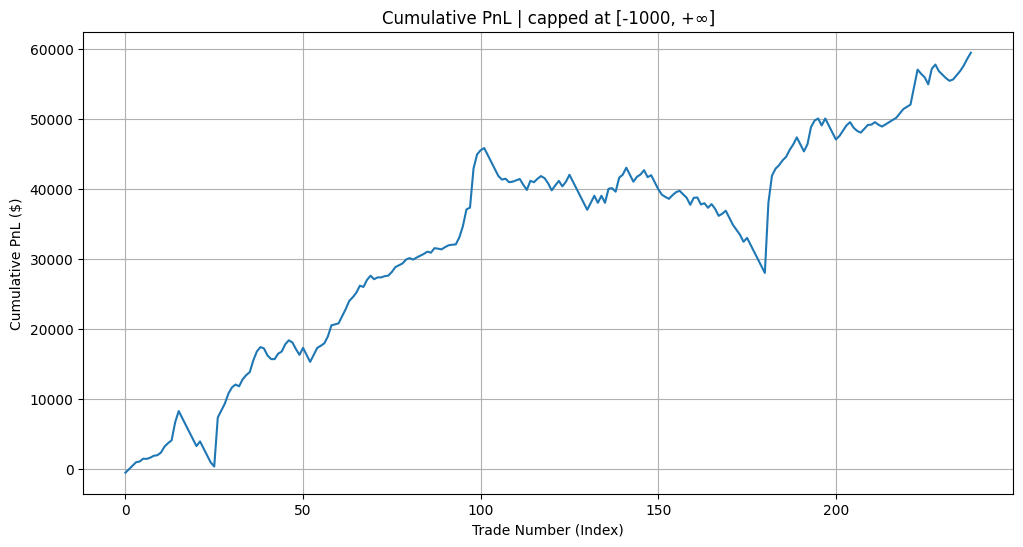

In [21]:
lower_outlier_filter = -1000
upper_outlier_filter = None
print("Insight: PnL totally wrecked by two heavy days of market weakness. The habit to change would be not to average down when the trade goes against you.")
print("Take the loss on the initial bet, don't be arrogant about that decision.") 
print("Either stay out when action is choppy and negative, or find the nerve and build the skill to sell into weakness.")
plot_cumulative_pnl(performance_df, min_pnl=None, max_pnl=None)

print("Insight: Had you obeyed a -$1000 per trade risk parameter, your performance would have improved monumentally.")
print("You need to review the impact of obeyence of risk parameter on PnL figures. Enlighten yourself on why you did so well between trade 25 and 125.")
print("Your attitude, behavioral patterns, and their interactions with the technical/fundamental environments of the time are key to maintaining consistent profitability")
plot_cumulative_pnl(performance_df, min_pnl=lower_outlier_filter, max_pnl=upper_outlier_filter)

This is the worst possible Monte Carlo contingency without PnL filtering.


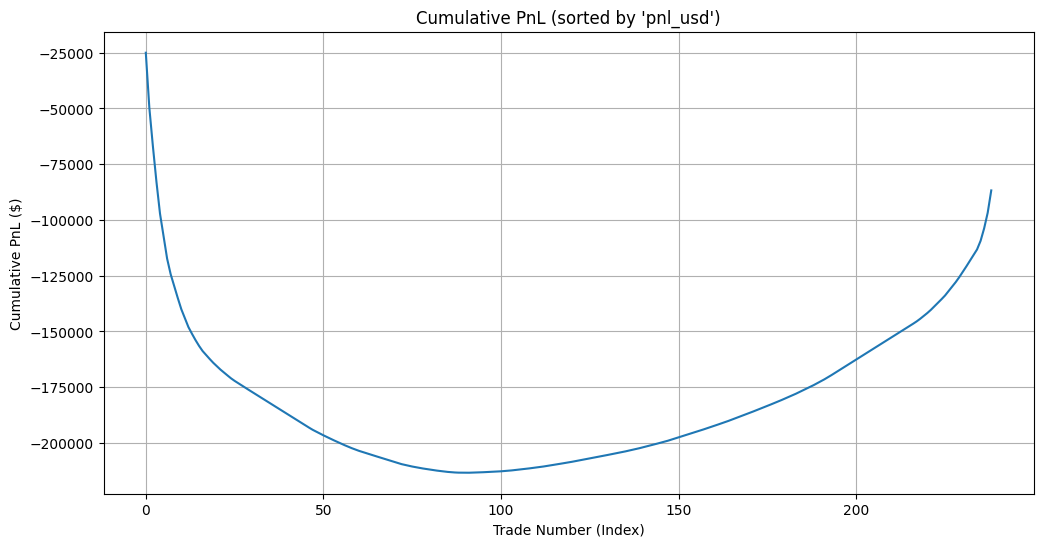

This is the worst possible Monte Carlo contingency under the assumption of strict per trade risk parameter obeyence.


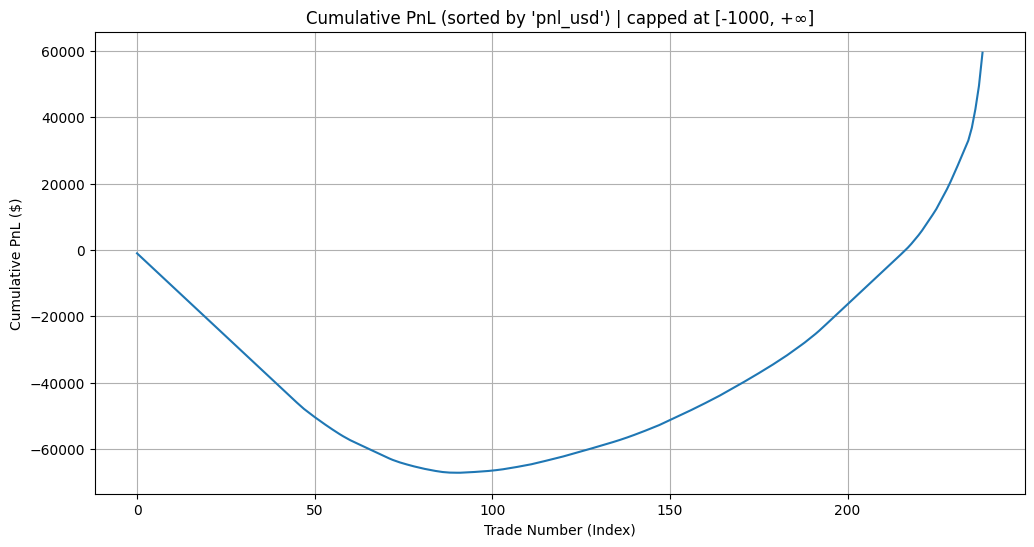

This chart is sorted by trade duration before calculating a temporary cumulative PnL. It may suggest that a certain trade duration marks an inflection point
where longer duration past that point makes a trade less likely to be profitable. The implication being that if a trade has been in the red for a long time,
it might be advisable to cut loss and look for a new setup.


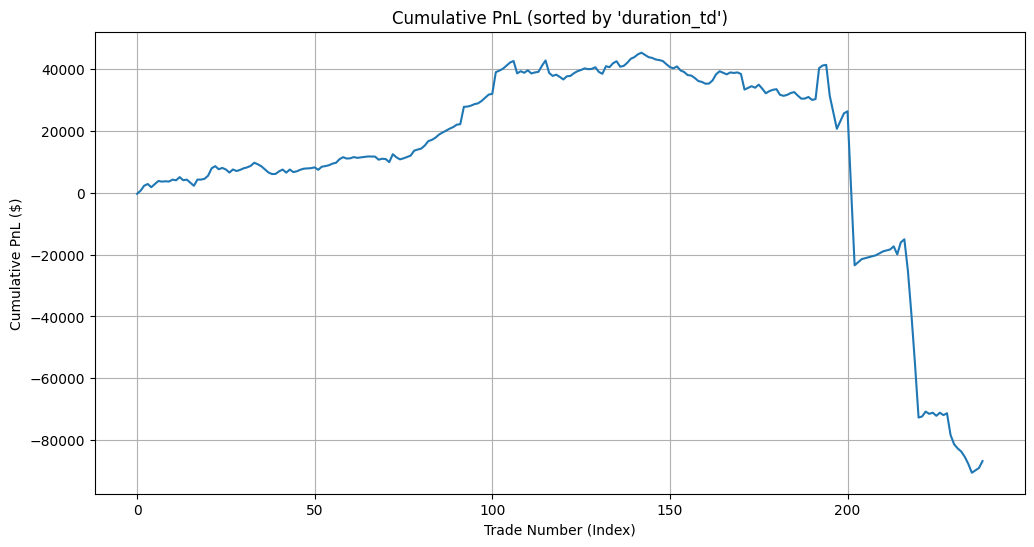

In [22]:
print("This is the worst possible Monte Carlo contingency without PnL filtering.")
plot_cumulative_pnl(performance_df, sort_by='pnl_usd', ascending=True, min_pnl=None, max_pnl=None)

print("This is the worst possible Monte Carlo contingency under the assumption of strict per trade risk parameter obeyence.")
plot_cumulative_pnl(performance_df, sort_by='pnl_usd', ascending=True, min_pnl=lower_outlier_filter, max_pnl=upper_outlier_filter)

print("This chart is sorted by trade duration before calculating a temporary cumulative PnL. It may suggest that a certain trade duration marks an inflection point")
print("where longer duration past that point makes a trade less likely to be profitable. The implication being that if a trade has been in the red for a long time,")
print("it might be advisable to cut loss and look for a new setup.")
plot_cumulative_pnl(performance_df, sort_by='duration_td', ascending=True, min_pnl=None, max_pnl=None)

# <h1 style="color:red;">Micro Trade Performance</h>

In [23]:
display(performance_df[['bought_ts', 'sold_ts', 'trade_direction', 'trade_outcome']])
display(minute_df)

,bought_ts,sold_ts,trade_direction,trade_outcome
0,2025-10-03 04:32:25,2025-10-03 05:44:23,long,loss
1,2025-10-08 05:45:54,2025-10-08 06:20:11,long,win
2,2025-10-08 06:36:23,2025-10-08 06:47:37,long,win
3,2025-10-08 07:45:57,2025-10-08 08:11:32,long,win
4,2025-10-08 11:32:21,2025-10-08 09:16:01,short,win
...,...,...,...,...
234,2025-12-30 00:23:39,2025-12-29 22:10:09,short,win
235,2025-12-30 07:39:14,2025-12-30 07:49:23,long,win
236,2025-12-30 07:42:10,2025-12-30 07:49:23,long,win
237,2025-12-30 08:13:27,2025-12-30 09:18:01,long,win


,open,high,low,close,volume,datetime,ticker
0,"6,767.0000","6,767.2500","6,766.7500","6,766.7500",125,2025-10-02 04:35:00,/ES
1,"6,766.7500","6,767.7500","6,766.2500","6,767.5000",372,2025-10-02 04:40:00,/ES
2,"6,767.7500","6,769.5000","6,767.7500","6,768.5000",414,2025-10-02 04:45:00,/ES
3,"6,768.5000","6,769.0000","6,767.7500","6,768.7500",231,2025-10-02 04:50:00,/ES
4,"6,768.5000","6,769.0000","6,768.2500","6,769.0000",206,2025-10-02 04:55:00,/ES
...,...,...,...,...,...,...,...
17085,"6,927.2500","6,928.2500","6,925.7500","6,925.7500",283,2025-12-31 09:20:00,/ES
17086,"6,926.0000","6,926.5000","6,924.7500","6,925.7500",467,2025-12-31 09:25:00,/ES
17087,"6,925.7500","6,926.5000","6,925.5000","6,925.7500",229,2025-12-31 09:30:00,/ES
17088,"6,925.7500","6,927.5000","6,925.7500","6,927.2500",352,2025-12-31 09:35:00,/ES


In [24]:
performance_df['bought_ts']

0     2025-10-03 04:32:25
1     2025-10-08 05:45:54
2     2025-10-08 06:36:23
3     2025-10-08 07:45:57
4     2025-10-08 11:32:21
              ...        
234   2025-12-30 00:23:39
235   2025-12-30 07:39:14
236   2025-12-30 07:42:10
237   2025-12-30 08:13:27
238   2025-12-30 09:41:35
Name: bought_ts, Length: 239, dtype: datetime64[ns]

In [25]:
# performance_df['trade_mae'] = 

# <h1 style="color:red;">Indicator Calculations</h>

In [26]:
def WMA(series, length):
    weights = np.arange(1, length + 1)
    return series.rolling(length).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

In [27]:
def add_wmas(df, length1=9, length2=21):
    df = df.copy()
    df[f'wma_{length1}'] = WMA(df['close'], length1)
    df[f'wma_{length2}'] = WMA(df['close'], length2)
    return df

In [28]:
def add_session_vwap(df, session_col='session'):
    df = df.copy()

    tp = (df['high'] + df['low'] + df['close']) / 3
    pv = tp * df['volume']

    df['cum_pv'] = pv.groupby(df[session_col]).cumsum()
    df['cum_vol'] = df['volume'].groupby(df[session_col]).cumsum()

    df['vwap'] = df['cum_pv'] / df['cum_vol']

    return df.drop(columns=['cum_pv', 'cum_vol'])

In [29]:
def add_session_vwap_bands(df, window=30, session_col='session'):
    df = df.copy()

    tp = (df['high'] + df['low'] + df['close']) / 3
    diff = tp - df['vwap']

    df['vwap_std'] = diff.groupby(df[session_col]).transform(
        lambda x: x.rolling(window).std()
    )

    df['vwap_upper1'] = df['vwap'] + df['vwap_std']
    df['vwap_lower1'] = df['vwap'] - df['vwap_std']
    df['vwap_upper2'] = df['vwap'] + 2 * df['vwap_std']
    df['vwap_lower2'] = df['vwap'] - 2 * df['vwap_std']

    return df

In [30]:
def add_pivots(df):
    df = df.copy()

    df['pivot'] = (df['high'] + df['low'] + df['close']) / 3

    df['R1'] = 2*df['pivot'] - df['low']
    df['S1'] = 2*df['pivot'] - df['high']

    df['R2'] = df['pivot'] + (df['high'] - df['low'])
    df['S2'] = df['pivot'] - (df['high'] - df['low'])

    df['R3'] = df['high'] + 2*(df['pivot'] - df['low'])
    df['S3'] = df['low'] - 2*(df['high'] - df['pivot'])

    return df

In [31]:
def add_all_rsi(df, length=14):
    df = df.copy()
    close = df['close']

    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder's RSI
    avg_gain_w = gain.ewm(alpha=1/length, adjust=False).mean()
    avg_loss_w = loss.ewm(alpha=1/length, adjust=False).mean()
    rs_w = avg_gain_w / avg_loss_w
    df['rsi_wilder'] = 100 - (100 / (1 + rs_w))

    # Simple SMA RSI
    avg_gain_s = gain.rolling(length).mean()
    avg_loss_s = loss.rolling(length).mean()
    rs_s = avg_gain_s / avg_loss_s
    df['rsi_sma'] = 100 - (100 / (1 + rs_s))

    # EMA RSI
    avg_gain_e = gain.ewm(span=length, adjust=False).mean()
    avg_loss_e = loss.ewm(span=length, adjust=False).mean()
    rs_e = avg_gain_e / avg_loss_e
    df['rsi_ema'] = 100 - (100 / (1 + rs_e))

    return df

In [32]:
def add_wma_signal(df, length=50):
    df = df.copy()
    df[f'wma_{length}'] = WMA(df['close'], length)
    df['price_vs_wma'] = np.sign(df['close'] - df[f'wma_{length}'])
    return df

In [33]:
def enrich_all_indicators(df):
    df = df.copy()

    # Ensure datetime sorted
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')

    # Simple session definition (calendar day)
    if 'session' not in df.columns:
        df['session'] = df['datetime'].dt.date

    df = add_session_vwap(df, session_col='session')
    df = add_session_vwap_bands(df, window=30, session_col='session')
    df = add_wmas(df, length1=9, length2=21)
    df = add_pivots(df)
    df = add_all_rsi(df, length=14)
    df = add_wma_signal(df, length=50)

    return df

In [34]:
# Ensure datetime is parsed
# minute_df['datetime'] = pd.to_datetime(minute_df['datetime'])
# minute_df = minute_df.sort_values('datetime')

# Apply full indicator suite
minute_df = enrich_all_indicators(minute_df)

# Save enriched dataset
minute_df.to_csv("ES_1min_with_indicators.csv", index=False)

print("Indicators added. Columns now include:")
print(minute_df)

Indicators added. Columns now include:
            open       high        low      close  volume            datetime ticker     session       vwap  vwap_std  vwap_upper1  vwap_lower1  vwap_upper2  vwap_lower2      wma_9     wma_21      pivot         R1         S1         R2         S2         R3         S3  rsi_wilder  rsi_sma  rsi_ema     wma_50  price_vs_wma
0     6,767.0000 6,767.2500 6,766.7500 6,766.7500     125 2025-10-02 04:35:00    /ES  2025-10-02 6,766.9167       NaN          NaN          NaN          NaN          NaN        NaN        NaN 6,766.9167 6,767.0833 6,766.5833 6,767.4167 6,766.4167 6,767.5833 6,766.0833         NaN      NaN      NaN        NaN           NaN
1     6,766.7500 6,767.7500 6,766.2500 6,767.5000     372 2025-10-02 04:40:00    /ES  2025-10-02 6,767.1038       NaN          NaN          NaN          NaN          NaN        NaN        NaN 6,767.1667 6,768.0833 6,766.5833 6,768.6667 6,765.6667 6,769.5833 6,765.0833    100.0000      NaN 100.0000        NaN    